In [1]:
import numpy as np
from matplotlib import pyplot as plt
from helpers import normalize_dataset

In [2]:
def one_hot_encode(labels: np.ndarray):
    '''
    one-hot encode labels
    @param labels 1D array of labels
    
    @return one-hot encoded labels
    '''
    casted_labels = labels.astype(int)
    return np.eye(np.unique(casted_labels).shape[0])[casted_labels]

def reshape_flat_square_images(images: np.ndarray):
    '''
    reshape to be a grayscale square
    @param image N x TOTAL_PIXELS

    @return N x 1 x HEIGHT x WIDTH
    '''
    dims = np.sqrt(images.shape[1])
    if not dims.is_integer():
        raise ValueError('Image is not square')
    dims = int(dims)
    return images.reshape(images.shape[0], 1, dims, dims)

In [3]:
training = np.loadtxt("dataset/train.csv",
                 delimiter=",", dtype=str) # load training data
training_labels = one_hot_encode(training[1:, 0]) # first column is labels
training_data = reshape_flat_square_images(normalize_dataset(training[1:, 1:])) # rest of columns are data

# Training Samples: 38000
# Classes: 10
Image Height: 28
Image Width: 28


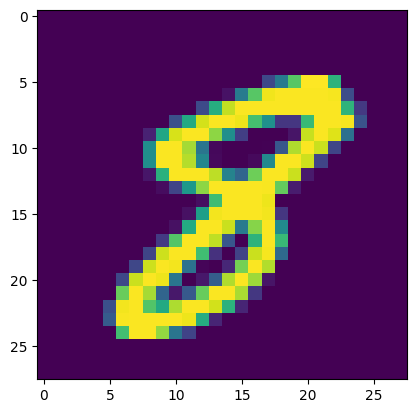

In [4]:
print("# Training Samples: " + str(training_labels.shape[0]))
print("# Classes: " + str(training_labels.shape[1]))
print("Image Height: " + str(training_data.shape[2]))
print("Image Width: " + str(training_data.shape[3]))
plt.imshow(training_data[0, 0]) # show first image in training set

In [10]:
def im2col(data: np.ndarray, conv: np.ndarray, stride: int, pad: int):
    '''
    transforms a batch of images into a matrix
    
    @param data N x 1 x HEIGHT x WIDTH input images
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    @param pad number of pixels to pad the image with

    @return CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES matrix
    '''
    data_padded = np.pad(data, ((0,0), (0,0), (pad, pad), (pad, pad)), mode='constant')
    num_images, num_channels, image_height, image_width = data_padded.shape
    conv_height = conv.shape[2]
    conv_width = conv.shape[3]
    output_height = int((image_height + (2 * pad) - conv_height) / stride) + 1
    output_width = int((image_width + (2 * pad) - conv_width) / stride) + 1
    
    # create a 4D view of the padded data to extract image patches
    # view has shape (num_images, num_channels, output_height, output_width, conv_height, conv_width)
    data_view = np.lib.stride_tricks.as_strided(data_padded,
                                                shape=(num_images, num_channels, output_height, output_width, conv_height, conv_width),
                                                strides=(data_padded.strides[0], data_padded.strides[1], 
                                                         stride * data_padded.strides[2], stride * data_padded.strides[3], 
                                                         data_padded.strides[2], data_padded.strides[3]))
    
    # reshape the view to a 2D array
    # the shape of the array is (num_images * output_height * output_width, num_channels * conv_height * conv_width)
    im2col_vector = data_view.reshape(num_images * output_height * output_width, num_channels * conv_height * conv_width)
    
    return im2col_vector.T # transpose the matrix to match the expected output shape

def convolve(data: np.ndarray, im2col_result: np.ndarray, conv: np.ndarray, stride: int):
    '''
    convolves the data with the im2col result
    @param data N x 1 x HEIGHT x WIDTH input images
    @param im2col_result CONV_HEIGHT * CONV_WIDTH x NEW_WIDTH * NEW_HEIGHT * NUM_IMAGES matrix
    @param conv NUM_FILTERS x 1 x CONV_HEIGHT x CONV_WIDTH convolutional layer
    @param stride number of pixels to move the filter each time
    
    @return NUM_IMAGES x NUM_FILTERS x NEW_HEIGHT x NEW_WIDTH matrix
    '''
    num_images, _, height, width = data.shape
    num_filters, _, conv_height, conv_width = conv.shape
    new_height = int(((height - conv_height) / stride)) + 1
    new_width = int(((width - conv_width) / stride)) + 1
    
    im2col_reshaped = im2col_result.reshape(conv_height * conv_width, new_width * new_height * num_images)
    conv_reshaped = conv.reshape(num_filters, -1)
    
    output = np.empty((num_images, num_filters, new_height, new_width))
    
    for i in range(num_images):
        convolved = conv_reshaped @ im2col_reshaped[:, i * new_height * new_width:(i + 1) * new_height * new_width]
        output[i] = convolved.reshape(num_filters, new_height, new_width)
    
    return output

def ReLU(x: np.ndarray):
    '''
    Rectified Linear Unit activation function
    
    @param x input to the activation function
    @return x if x > 0, 0 otherwise
    '''
    return (x > 0) * x

def maxpool(input_image: np.ndarray, output_shape: np.shape, pool_size: int, strides: int):
    '''
    computes the maxpool of the input image
    @param input_image CHANNELS x HEIGHT x WIDTH input image
    @param output_shape dimensions of the output image (HEIGHT x WIDTH shape)
    @param pool_size size of the pooling window
    @param strides number of pixels to move the pooling window each time
    
    @return CHANNELS x NEW_HEIGHT x NEW_WIDTH matrix
    '''
    channels, height, width = input_image.shape

    # Reshape input image for efficient pooling
    pool_shape = (channels, output_shape[0], pool_size, output_shape[1], pool_size)
    pool_strides = (height * width * channels * strides * strides, width * pool_size * channels * strides, 
                    pool_size * channels * strides, 
                    width * strides * channels, pool_size * channels, 
                    strides * channels, width * strides, strides, 
                    1)
    pool_image = np.lib.stride_tricks.as_strided(input_image, shape=pool_shape, strides=pool_strides)

    # Perform max pooling using matrix multiplication
    pool_image = pool_image.reshape(channels, output_shape[0], output_shape[1], pool_size * pool_size)
    output = np.max(pool_image, axis=-1)

    return output


def maxpool_multiple(data: np.ndarray, pool_size: int, stride: int):
    '''
    computes the maxpooling of the input data
    @param data N x CHANNELS x HEIGHT x WIDTH input images
    @param pool_size size of the pooling filter
    @param strides number of pixels to move the filter each time
    
    @return N x CHANNELS x NEW_HEIGHT x NEW_WIDTH matrix
    '''
    batch_size, channels, height, width = data.shape

    # Compute output shape
    out_height = int((height - pool_size) / stride) + 1
    out_width = int((width - pool_size) / stride) + 1

    # Initialize output image
    output_image = np.zeros((batch_size, channels, out_height, out_width))

    # Perform max pooling for each image in the batch
    for i in range(batch_size):
        output_image[i] = maxpool(data[i], (out_height, out_width), pool_size, stride)

    return output_image

In [6]:
num_filters = 2
conv_filter_size = 5
conv_stride = 1
conv_layer = np.random.randn(num_filters, 1, conv_filter_size, conv_filter_size) * np.sqrt(1. / conv_filter_size)
display(conv_layer.shape)

(2, 1, 5, 5)

In [7]:
single_im2col = im2col(training_data[0:1], conv_layer, conv_stride, 0) # only use one image
display(single_im2col.shape)

(25, 576)

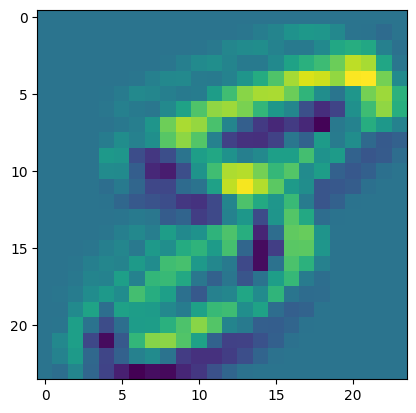

In [8]:
single_conv = convolve(training_data[0:1], single_im2col, conv_layer, conv_stride) # convolve the first training image with the first filter
plt.imshow(single_conv[0, 0])

In [11]:
maxpool_size = 2
maxpool_stride = 2
single_maxpool = maxpool_multiple(single_conv[0:1], maxpool_size, maxpool_stride) # maxpool the first image
plt.imshow(single_maxpool[0, 0])

ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
# initialize weights and biases
W1 = np.random.rand(60, 288) / np.sqrt(288)
B0 = np.zeros((60, 1)) / np.sqrt(288)
W2 = np.random.rand(10, 60) / np.sqrt(60)
B1 = np.zeros((10, 1)) / np.sqrt(60)
learning_rate = 0.001